# Tutorial 1 - Simulated data 

In this tutorial, we explore the ability of `sccoral` to retrieve known ground truths from single-cell data. For this purpose, we simulated single-cell data with `Splatter` [^splatter] and Seqgendiff [^seqgendiff] and introduced known ground truths in the data that represent our factors of interest.

We will investigate 

1. If `sccoral` faithfully recovers the ground truth expression
2. Compare the results with another commonly used factor analysis method (`NMF`)

In [1]:
# Basic data analysis
import pandas as pd
import scanpy as sc

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Factor analysis
import sccoral

/tmp/ipykernel_401539/1968393896.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/lucas/anaconda3/envs/sccoral/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/lucas/anaconda3/envs/sccoral/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memo

In [2]:
sc.settings.set_figure_params(figsize=(3, 3), frameon=False)

First, we retrieve our data from figshare using the {func}`sccoral.data.splatter_simulation` function. 

In [3]:
adata = sccoral.data.splatter_simulation("/tmp", "splatter-simulation.h5ad")
adata

AnnData object with n_obs × n_vars = 4000 × 5000
    obs: 'sample_id', 'categorical_covariate', 'continuous_covariate'
    var: 'mean', 'std'
    uns: 'log1p', 'neighbors', 'pca', 'simulation_param', 'umap'
    obsm: 'X_pca', 'X_umap', 'program_usage'
    varm: 'PCs', 'program_loading'
    layers: 'counts', 'scaled'
    obsp: 'connectivities', 'distances'

The {func}`anndata.AnnData` object has already been processed and contains everything necessary for the downstream analysis. It stores the ground truth gene programs in its `.obsm` (program/factor usage) and `.varm` (program/factor loading) attributes. We have also computed a UMAP projection for the data. Let's take a look at the ground truth gene programs in the data.

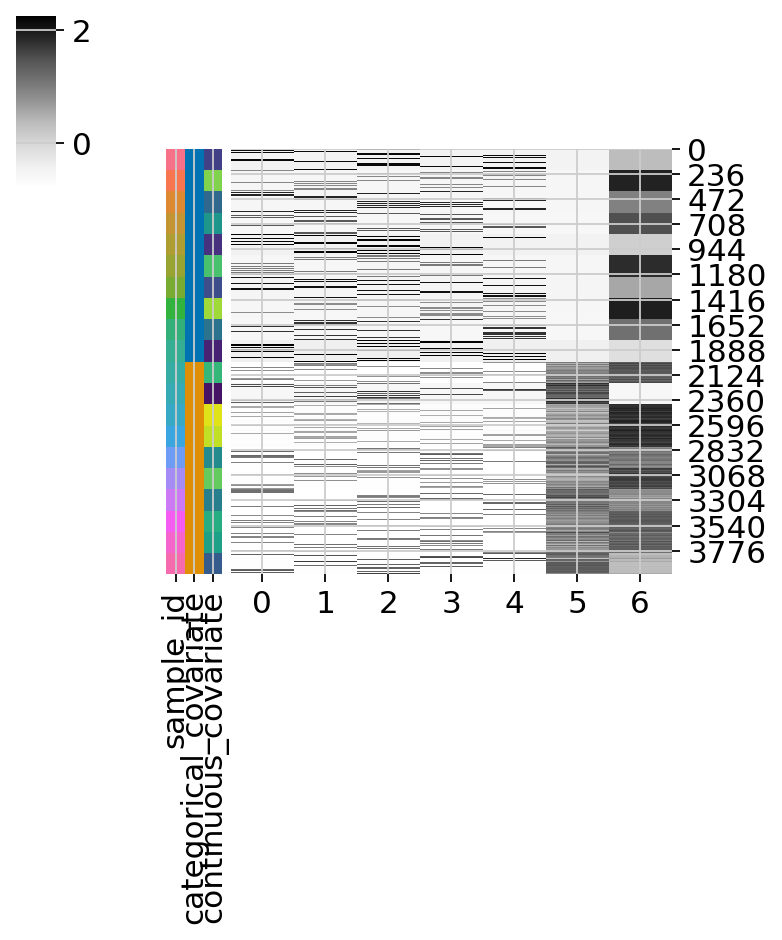

In [4]:
sample_color_mapping = dict(
    zip(adata.obs["sample_id"].unique(), sns.color_palette("husl", adata.obs["sample_id"].nunique()))
)
sample_coloring = adata.obs["sample_id"].apply(lambda x: sample_color_mapping[x])

sample_category_mapping = dict(
    zip(
        adata.obs["categorical_covariate"].unique(),
        sns.color_palette("colorblind", adata.obs["categorical_covariate"].nunique()),
    )
)
category_coloring = adata.obs["categorical_covariate"].apply(lambda x: sample_category_mapping[x])

sample_category_mapping = dict(
    zip(
        sorted(adata.obs["continuous_covariate"].unique()),
        sns.color_palette("viridis", adata.obs["continuous_covariate"].nunique()),
    )
)
continuous_coloring = adata.obs["continuous_covariate"].apply(lambda x: sample_category_mapping[x])


sns.clustermap(
    pd.DataFrame(adata.obsm["program_usage"], index=adata.obs_names),
    cmap="Grays",
    z_score=False,
    col_cluster=False,
    row_cluster=False,
    row_colors=pd.concat([sample_coloring, category_coloring, continuous_coloring], axis=1),
    figsize=(5, 6),
)
plt.show()

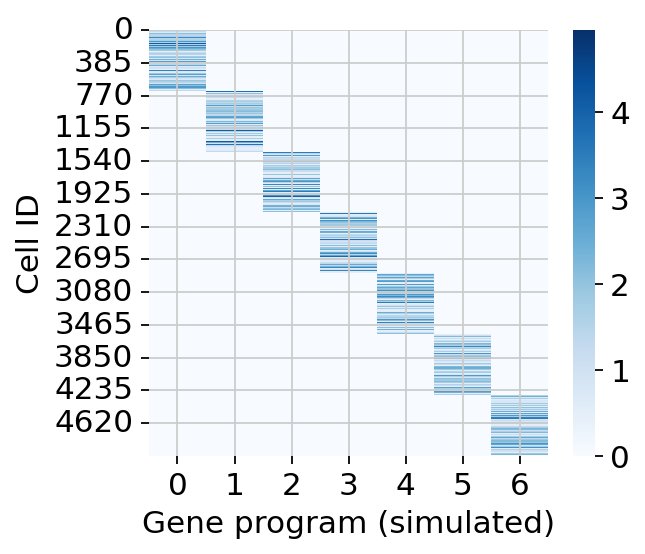

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
sns.heatmap(pd.DataFrame(adata.varm["program_loading"], index=adata.var_names), cmap="Blues", ax=ax)
ax.set(xlabel="Gene program (simulated)", ylabel="Cell ID")
plt.show()

We see that the single-cell gene expression is simulated based on 7 orthogonal and sparse gene programs (left figure). Every cell expresses 1 *identity program* (Gene program 0-4) and 2 *sample-specific programs*. One sample-specific program is categorical and either on/off, depending on the sample identity, while the other program usage varies depending on the sample identity. Sample-specific program usages are directly linked to artificialy metadata stored in the `categorical_covariate`/`continuous covariate` fields in the {func}`adata.obs` attribute


This is also visible when looking at the UMAP projection of the counts. Cells clearly separate based on the categorical/continuous covariates and their identity programs. 

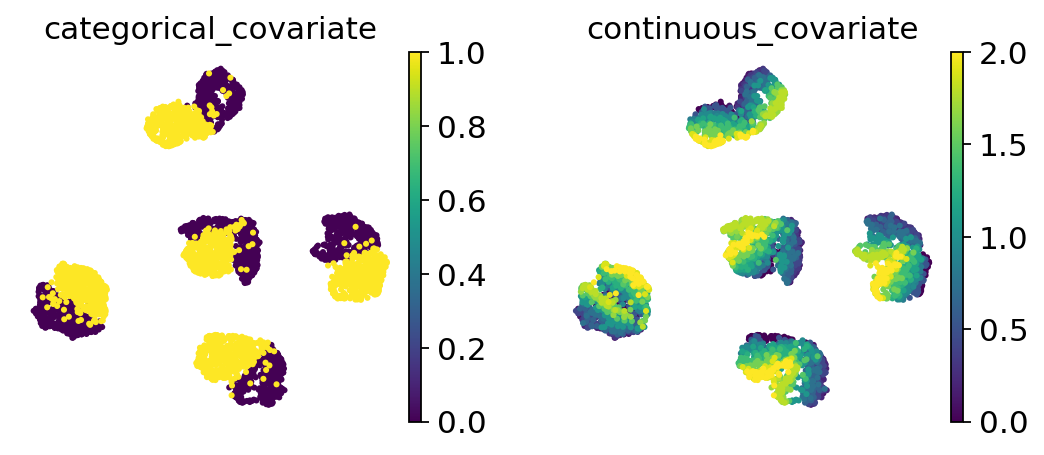

In [6]:
sc.pl.umap(adata, color=["categorical_covariate", "continuous_covariate"])

Now let's setup our sccoral model with the aim to recover these gene programs.As we know the true number of gene programs (7), let's use 7 latent dimensions.



In [7]:
%%capture
sccoral.model.SCCORAL.setup_anndata(adata)
model = sccoral.model.SCCORAL(adata, n_latent=7)

Per default, `sccoral` training includes a pretraining step in which the weights of the counts encoder are frozen. The model therefore only learns on the metadata. Only after this pretraining step, we start to train the model on counts+metadata. 

In [8]:
model.train(max_epochs=1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 722/1000:  72%|███████▏  | 721/1000 [11:06<04:23,  1.06it/s, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.44e+3]

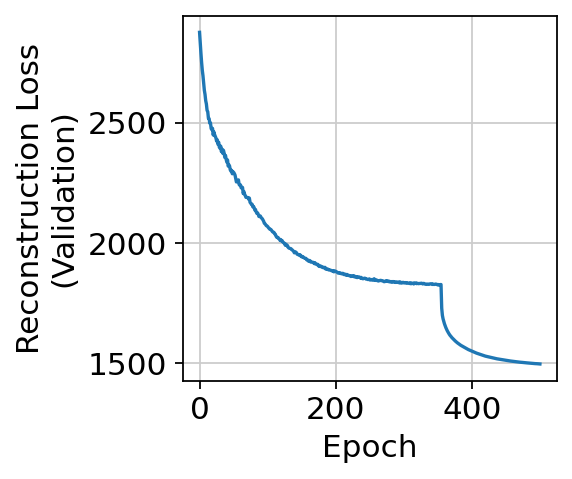

In [ ]:
plt.plot(model.history["validation_loss"])
plt.gca().set(xlabel="Epoch", ylabel="Reconstruction Loss\n(Validation)")
plt.show()

In [ ]:
model.get_loadings()

[^splatter] Zappia, L., Phipson, B. & Oshlack, A. Splatter: simulation of single-cell RNA sequencing data. Genome Biol 18, 174 (2017).

[^seqgendiff] Gerard, D. Data-based RNA-seq simulations by binomial thinning. BMC Bioinformatics 21, 206 (2020).
